# Partie 1 : Perceptron

In [ ]:
%run perceptron_pytorch.py

C:\Users\lenovo\Downloads\M2\IA-BIML\perceptron_pytorch.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ((data_train,label_train),(data_test,label_test)) = torch.load(g

taille de data_train torch.Size([63000, 784])  => avec 63000 comme nombre d'images et chacune avec 784 dimentions
taille de label_train torch.Size([63000, 10])  => chaque image est representer par 10 chiffres
taille de data_train torch.Size([7000, 784])
taille de label_train torch.Size([7000, 10])
taille de W torch.Size([784, 10]) => on crée 784 weight pour chaque connection (784 en totale)  entre l'entrer x et notre neuronne
taille de b torch.Size([1, 10]) => meme chose pour le bias
taille de l'entrée x torch.Size([5, 784]) => chaque fois on prend 5 images
taille de la sortie y torch.Size([5, 10])
taille de label t qui doit etre identique a celle de y torch.Size([5, 10])
taille de grad torch.Size([5, 10])
tensor([0.8010])
tensor([0.8249])
tensor([0.8384])
tensor([0.8404])
tensor([0.8444])
tensor([0.8477])
tensor([0.8507])
tensor([0.8514])
tensor([0.8520])
tensor([0.8534])


On a un neurone qui accepte 784 pixels en entrée, mais en effet, dans l'entraînement on a fait l'entraînement seulement en prenant 5 entrées (batch size) à chaque fois (ces cinq sont aléatoires pour éviter le problème de surapprentissage). À chaque itération, on calcule le gradient et on met à jour nos poids, et finalement on affiche pour chacune des 10 (le nb_epochs) itérations le pourcentage des bons résultats après entraînement de notre neuronne.

# Partie 2 : Shallow network

## Méthodologie

Notre modèle neuronal conçu se compose d'une couche cachée utilisant la fonction d'activation ReLU, suivie d'une couche de sortie. On utilisera également le crossentropy comme fonction de perte pour l'évaluation. Ce choix était pris puisque l'on a une tâche de classification de multi-classes, réf : https://medium.com/@l228104/understanding-cross-entropy-loss-and-its-role-in-classification-problems-d2550f2caad5

L'approche adoptée pour l'optimisation des hyperparamètres repose sur une recherche en grille, explorant systématiquement diverses combinaisons de tailles de lots, taux d'apprentissage et nombres de neurones dans la couche cachée.
Le processus d'entraînement intègre une stratégie de validation croisée, où 20% des données d'entraînement sont réservées à la validation. Cette approche permet une évaluation de la performance du modèle sur des données non vues pendant l'entraînement, contribuant ainsi à la sélection du meilleur ensemble d'hyperparamètres.
Nous utiliserons la technique d'Early Stopping pour éviter le surapprentissage (overfitting), en surveillant les performances du modèle sur le jeu de validation. Si la perte de validation ne s'améliore pas pendant un certain nombre d'époques (défini par la patience), l'entraînement sera interrompu avant la fin prévue des époques, permettant ainsi de réduire la complexité du modèle et d'éviter un ajustement excessif aux données d'entraînement.
L'évaluation finale du modèle est réalisée sur un ensemble de test distinct, garantissant une estimation non biaisée de la performance générale du modèle optimisé sur des données totalement inédites.

In [6]:
import gzip
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler

# Définition de la classe du réseau
class ShallowNeuralNetwork(nn.Module):
    def __init__(self, input_num, hidden_num, output_num):
        super(ShallowNeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_num, hidden_num)  # Couche cachée
        self.output = nn.Linear(hidden_num, output_num)  # Couche de sortie
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        return self.output(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience=5):
    best_val_loss = float('inf')
    best_val_acc = 0
    best_model_state = model.state_dict()
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        for x, t in train_loader:
            optimizer.zero_grad()  # Réinitialisation des gradients
            y = model(x)  # Propagation avant
            loss = criterion(y, t)  # Calcul de la perte
            loss.backward()  # Rétropropagation
            optimizer.step()  # Mise à jour des poids

        model.eval()  # Passage en mode évaluation
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():  # Désactivation du calcul des gradients pour l'évaluation
            for x, t in val_loader:
                y = model(x)
                val_loss += criterion(y, t).item()
                _, predicted = torch.max(y.data, 1)
                _, target = torch.max(t.data, 1)
                total += t.size(0)
                correct += (predicted == target).sum().item()  # Nombre de prédictions correctes

        val_loss /= len(val_loader)  # Calcul de la perte moyenne
        val_acc = correct / total  # Calcul de la précision

        # Mise à jour du meilleur modèle si la précision s'améliore
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1

        # Early stopping si pas d'amélioration pendant 'patience' époques
        if no_improve >= patience:
            print(f"Early stopping à l'époque {epoch+1}")
            break

    model.load_state_dict(best_model_state)  # Chargement du meilleur modèle
    return model, best_val_loss, best_val_acc

# Fonction pour évaluer le modèle
def evaluate(model, data_loader):
    correct = 0
    total = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss()  # Fonction de perte pour l'évaluation
    with torch.no_grad():  # Désactivation du calcul des gradients
        for x, t in data_loader:
            y = model(x)
            loss = criterion(y, t)
            total_loss += loss.item()  # Cumul de la perte
            _, predicted = torch.max(y.data, 1)
            _, target = torch.max(t.data, 1)
            total += t.size(0)
            correct += (predicted == target).sum().item()
    return correct / total, total_loss / len(data_loader)

# Chargement des données
((data_train, label_train), (data_test, label_test)) = torch.load(gzip.open('mnist.pkl.gz'))

# la séparation entraînement/validation
validation_split = 0.2
dataset_size = len(data_train)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Définition des hyperparamètres à tester
batch_sizes = [32, 64, 128]
learning_rates = [0.00001 ,0.001, 0.01, 0.1]
hidden_sizes = [50, 100, 200] # nombres de neuronnes dans les couches cachées
epochs = 100

best_val_loss = float('inf')
best_val_acc = 0
best_params = {}

# Boucle d'hyperparamétrage
for batch_size in batch_sizes:
    for lr in learning_rates:
        for hidden_size in hidden_sizes:
            # DataLoaders pour l'entraînement et la validation
            train_loader = DataLoader(TensorDataset(data_train, label_train), batch_size=batch_size, sampler=train_sampler)
            val_loader = DataLoader(TensorDataset(data_train, label_train), batch_size=batch_size, sampler=val_sampler)

            model = ShallowNeuralNetwork(data_train.shape[1], hidden_size, 10)

            # Définition de la fonction de perte et de l'optimiseur
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            # Entraînement du modèle
            model, val_loss, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)

            print(f"Batch size: {batch_size}, LR: {lr}, Hidden size: {hidden_size}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

            # Mise à jour du meilleur modèle si la précision s'améliore
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_val_loss = val_loss
                best_params = {
                    'batch_size': batch_size,
                    'lr': lr,
                    'hidden_size': hidden_size
                }
                best_model = model

print("\nMeilleurs hyperparamètres:")
print(best_params)
print(f"Meilleure perte de validation: {best_val_loss:.4f}")
print(f"Meilleure précision de validation: {best_val_acc:.4f}")

test_loader = DataLoader(TensorDataset(data_test, label_test), batch_size=128)
test_acc, test_loss = evaluate(best_model, test_loader)
print(f"\nPrécision sur l'ensemble de test: {test_acc:.4f}")
print(f"Perte sur l'ensemble de test: {test_loss:.4f}")

<ipython-input-6-1d34138d2dda>:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ((data_train, label_train), (data_test, label_test)) = torch.load(gzip.open('mnist.pkl.gz'))

Batch size: 32, LR: 1e-05, Hidden size: 50, Validation Loss: 0.2133, Validation Accuracy: 0.9391
Batch size: 32, LR: 1e-05, Hidden size: 100, Validation Loss: 0.1776, Validation Accuracy: 0.9502
Batch size: 32, LR: 1e-05, Hidden size: 200, Validation Loss: 0.1414, Validation Accuracy: 0.9598
Early stopping à l'époque 16
Batch size: 32, LR: 0.001, Hidden size: 50, Validation Loss: 0.0961, Validation Accuracy: 0.9715
Early stopping à l'époque 27
Batch size: 32, LR: 0.001, Hidden size: 100, Validation Loss: 0.1121, Validation Accuracy: 0.9775
Early stopping à l'époque 26
Batch size: 32, LR: 0.001, Hidden size: 200, Validation Loss: 0.1062, Validation Accuracy: 0.9807
Early stopping à l'époque 14
Batch size: 32, LR: 0.01, Hidden size: 50, Validation Loss: 0.1799, Validation Accuracy: 0.9619
Early stopping à l'époque 11
Batch size: 32, LR: 0.01, Hidden size: 100, Validation Loss: 0.1719, Validation Accuracy: 0.9629
Early stopping à l'époque 11
Batch size: 32, LR: 0.01, Hidden size: 200, Val

## Résultats

On observe que la performance s'améliore de manière significative lorsque la taille de la couche cachée augmente, ainsi que le taux d'apprentissage est bien ajusté. Par exemple, avec un taux d'apprentissage de 0.001 et une taille de batch de 128, la performance atteint une précision de validation de 98,10% avec une perte de 0.0868 pour une taille de couche cachée de 200. Ce résultat montre que l'augmentation du nombre de neurones dans la couche cachée permet au réseau de mieux capturer les complexités de la tâche de classification sur MNIST, tout en évitant le surapprentissage grâce à un mécanisme d'arrêt anticipé.

# Partie 3 : Deep network

## Méthodologie

On utilisera la même chose principalement que dans la ShallowNet. Nous allons définir un réseau de neurones profond, avec deux couches cachées, afin d'améliorer la capacité du modèle à capturer des patterns complexes dans les données. Nous allons ajuster les hyperparamètres tels que la taille des lots, le taux d'apprentissage et le nombre de neurones dans les couches cachées.
Nous utiliserons la technique d'Early Stopping et nous tracerons la courbe d'apprentissage montrant l'évolution de la perte au fil des époques pour mieux visualiser le processus d'optimisation.

<ipython-input-5-8b6b568b2438>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ((data_train, label_train), (data_test, label_test)) = torch.load(gzip.open('mnist.pkl.gz'))

Batch size: 32, LR: 1e-05, Hidden size: (32, 32), Validation Loss: 0.2805
Batch size: 32, LR: 1e-05, Hidden size: (64, 64), Validation Loss: 0.2354
Batch size: 32, LR: 1e-05, Hidden size: (50, 100), Validation Loss: 0.2443
Batch size: 32, LR: 1e-05, Hidden size: (100, 100), Validation Loss: 0.2101
Batch size: 32, LR: 1e-05, Hidden size: (100, 200), Validation Loss: 0.1912
Batch size: 32, LR: 1e-05, Hidden size: (200, 200), Validation Loss: 0.1564
Early stopping à l'époque 27
Batch size: 32, LR: 0.001, Hidden size: (32, 32), Validation Loss: 0.1743
Early stopping à l'époque 17
Batch size: 32, LR: 0.001, Hidden size: (64, 64), Validation Loss: 0.1291
Early stopping à l'époque 15
Batch size: 32, LR: 0.001, Hidden size: (50, 100), Validation Loss: 0.1290
Early stopping à l'époque 17
Batch size: 32, LR: 0.001, Hidden size: (100, 100), Validation Loss: 0.1260
Early stopping à l'époque 14
Batch size: 32, LR: 0.001, Hidden size: (100, 200), Validation Loss: 0.1145
Early stopping à l'époque 27


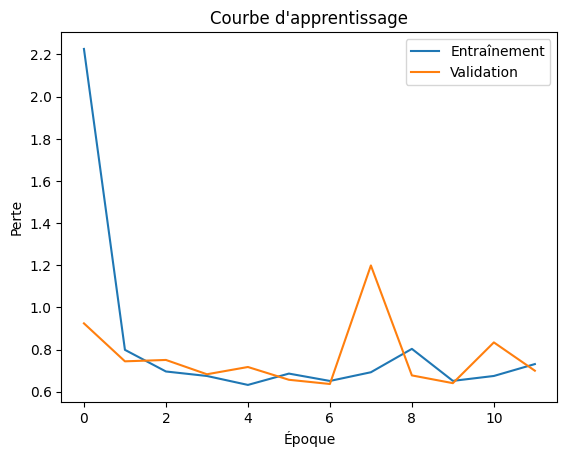


Précision sur l'ensemble de test: 0.9776
Perte sur l'ensemble de test: 0.0882


In [5]:
# Importation des bibliothèques nécessaires
import gzip
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt

# Définition de la classe du réseau de neurones profond
class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_num, hidden_num1, hidden_num2, output_num):
        super(DeepNeuralNetwork, self).__init__()
        self.hidden1 = nn.Linear(input_num, hidden_num1) # 1ere couche cachées
        self.hidden2 = nn.Linear(hidden_num1, hidden_num2)  # 2ème  couche cachées
        self.output = nn.Linear(hidden_num2, output_num)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        return self.output(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience=5):
    best_val_loss = float('inf')
    best_val_acc = 0
    best_model_state = model.state_dict()
    no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x, t in train_loader:
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, t)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))  # Sauvegarder la perte d'entraînement

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for x, t in val_loader:
                y = model(x)
                val_loss += criterion(y, t).item()
                _, predicted = torch.max(y.data, 1)
                _, target = torch.max(t.data, 1)
                total += t.size(0)
                correct += (predicted == target).sum().item()

        val_losses.append(val_loss / len(val_loader))  # Sauvegarder la perte de validation
        val_acc = correct / total

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"Early stopping à l'époque {epoch+1}")
            break

    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

def evaluate(model, data_loader):
    correct = 0
    total = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, t in data_loader:
            y = model(x)
            loss = criterion(y, t)
            total_loss += loss.item()
            _, predicted = torch.max(y.data, 1)
            _, target = torch.max(t.data, 1)
            total += t.size(0)
            correct += (predicted == target).sum().item()
    return correct / total, total_loss / len(data_loader)

((data_train, label_train), (data_test, label_test)) = torch.load(gzip.open('mnist.pkl.gz'))

validation_split = 0.2
dataset_size = len(data_train)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

batch_sizes = [32, 64, 128, 200]
learning_rates = [0.00001, .001, 0.01, 0.1]
hidden_sizes = [(32,32), (64, 64), (50, 100) , (100, 100),  (100, 200), (200, 200)]
epochs = 50

best_val_loss = float('inf')
best_val_acc = 0
best_params = {}

# Boucle d'hyperparamétrage
for batch_size in batch_sizes:
    for lr in learning_rates:
        for hidden_size in hidden_sizes:
            train_loader = DataLoader(TensorDataset(data_train, label_train), batch_size=batch_size, sampler=train_sampler)
            val_loader = DataLoader(TensorDataset(data_train, label_train), batch_size=batch_size, sampler=val_sampler)

            model = DeepNeuralNetwork(data_train.shape[1], hidden_size[0], hidden_size[1], 10)

            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            # Entraînement du modèle
            model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)

            print(f"Batch size: {batch_size}, LR: {lr}, Hidden size: {hidden_size}, Validation Loss: {val_losses[-1]:.4f}")

            if val_losses[-1] < best_val_loss:
                best_val_loss = val_losses[-1]
                best_params = {
                    'batch_size': batch_size,
                    'lr': lr,
                    'hidden_size': hidden_size
                }
                best_model = model

plt.plot(train_losses, label='Entraînement')
plt.plot(val_losses, label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Courbe d\'apprentissage')
plt.legend()
plt.show()

test_loader = DataLoader(TensorDataset(data_test, label_test), batch_size=128)
test_acc, test_loss = evaluate(best_model, test_loader)
print(f"\nPrécision sur l'ensemble de test: {test_acc:.4f}")
print(f"Perte sur l'ensemble de test: {test_loss:.4f}")

## Résultats

Les résultats obtenus pour la classification MNIST montrent une forte influence des paramètres de la taille du batch, du taux d'apprentissage (LR), et de la taille des couches cachées sur la performance du réseau de neurones. Pour un taux d'apprentissage de 1e-05, les performances s'améliorent à mesure que la taille des couches cachées augmente, avec une validation loss diminuant progressivement, atteignant une valeur minimale de 0.1564 pour la configuration (200, 200). Cependant, avec un LR de 0.001, des performances optimales sont observées avec des architectures de taille modérée comme (100, 200) et (200, 200), atteignant des validation losses respectivement de 0.1145 et 0.1076. Un taux d'apprentissage plus élevé (0.01 et 0.1) dégrade la performance, notamment avec des valeurs de validation loss très élevées à partir de LR 0.1, illustrant une sur-apprentissage rapide et inefficace, avec des arrêts précoces (early stopping) autour des premières époques. Les batch sizes plus importants, comme 128 et 200, combinés à un LR de 0.001, tendent à améliorer les performances, atteignant des validation losses aussi basses que 0.1029. À citer aussi dans la coube d'entraînement, même si c'était pas l'objectif principal, l'early stoping a mené un peu près à trouver un nombre d'époches plus **faible** pour notre raseau, avec un nombre plus faible (12 époches) que celui déjà posé dans le code (50 époches).

# Partie 4 : CNN

## Méthodologie

Pour cette partie de CNN nous avons opté pour utiliser l’architecture LeNet-5, conçue par Yann LeCun et al. en 1998, qui est un réseau de neurones convolutifs pionnier particulièrement adapté à la reconnaissance de chiffres manuscrits. Sa structure se compose d'une couche d'entrée pour des images 28x28 pixels en niveaux de gris, suivie de deux blocs de convolution-pooling et de trois couches entièrement connectées. Le premier bloc de convolution utilise 6 filtres, suivi d'une activation Tanh et d'un pooling moyen, tandis que le second utilise 16 filtres. Les couches entièrement connectées réduisent progressivement la dimensionnalité de 120 à 84, puis à 10 neurones pour la classification finale.

Pour l'entraînement et d'optimisation comme pour les autres parties nous avons utilisé  la descente de gradient stochastique avec mini-batches, l'entropie croisée comme fonction de perte, et l'optimiseur Adam pour ajuster dynamiquement les taux d'apprentissage.Nous  avons  implémenté l'early stopping aussi. La recherche d'hyperparamètres est effectuée systématiquement grâce à ParameterGrid de scikit-learn, explorant différentes combinaisons de tailles de batch, taux d'apprentissage et nombres d'époques.

L'évaluation du modèle se base sur la précision (accuracy), avec une séparation claire entre données d'entraînement et de test pour évaluer la généralisation. 

On visualise enfin  les courbes d'apprentissage pour analyser la progression de l'entraînement.

<ipython-input-8-921bc59236cf>:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ((data_train, label_train), (data_test, label_test)) = torch.load(gzip.open('mnist.pkl.gz'))

Params: {'batch_size': 32, 'epochs': 20, 'lr': 0.0001}, Validation Accuracy: 0.9884
Early stopping à l'époque 15
Params: {'batch_size': 32, 'epochs': 20, 'lr': 0.001}, Validation Accuracy: 0.9884
Early stopping à l'époque 14
Params: {'batch_size': 32, 'epochs': 20, 'lr': 0.01}, Validation Accuracy: 0.9439
Early stopping à l'époque 30
Params: {'batch_size': 32, 'epochs': 30, 'lr': 0.0001}, Validation Accuracy: 0.9894
Early stopping à l'époque 13
Params: {'batch_size': 32, 'epochs': 30, 'lr': 0.001}, Validation Accuracy: 0.9869
Early stopping à l'époque 7
Params: {'batch_size': 32, 'epochs': 30, 'lr': 0.01}, Validation Accuracy: 0.9451
Early stopping à l'époque 28
Params: {'batch_size': 32, 'epochs': 40, 'lr': 0.0001}, Validation Accuracy: 0.9889
Early stopping à l'époque 11
Params: {'batch_size': 32, 'epochs': 40, 'lr': 0.001}, Validation Accuracy: 0.9859
Early stopping à l'époque 13
Params: {'batch_size': 32, 'epochs': 40, 'lr': 0.01}, Validation Accuracy: 0.9414
Params: {'batch_size':

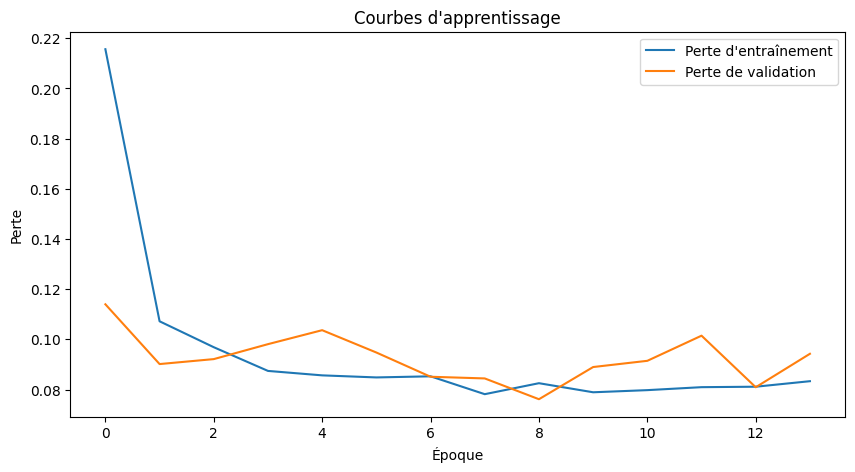

In [8]:
import gzip
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

# Définition de l'architecture LeNet-5
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5

        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        return self.classifier(self.feature(x))

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience=5):
    best_val_loss = float('inf')
    best_model_state = model.state_dict()
    no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x, t in train_loader:
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, t)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, t in val_loader:
                y = model(x)
                val_loss += criterion(y, t).item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"Early stopping à l'époque {epoch+1}")
            break

    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, t in data_loader:
            y = model(x)
            _, predicted = torch.max(y.data, 1)
            _, target = torch.max(t.data, 1)
            total +=  t.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

((data_train, label_train), (data_test, label_test)) = torch.load(gzip.open('mnist.pkl.gz'))

# Reshape des données pour LeNet-5 (28x28 et ajout d'une dimension de canal)
data_train = data_train.view(-1, 1, 28, 28)
data_test = data_test.view(-1, 1, 28, 28)

train_dataset = TensorDataset(data_train, label_train)
test_dataset = TensorDataset(data_test, label_test)

param_grid = {
    'batch_size': [32, 64, 128],
    'lr': [0.0001, 0.001, 0.01],
    'epochs': [20, 30, 40]
}

best_val_acc = 0
best_params = {}
best_model = None

# Boucle d'hyperparamétrage avec ParameterGrid
for params in ParameterGrid(param_grid):
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=params['batch_size'])

    model = LeNet5()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])

    model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, params['epochs'])

    val_acc = evaluate(model, val_loader)

    print(f"Params: {params}, Validation Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params
        best_model = model

print(f"\nMeilleurs hyperparamètres: {best_params}")
print(f"Meilleure précision de validation: {best_val_acc:.4f}")

test_loader = DataLoader(test_dataset, batch_size=128)
test_acc = evaluate(best_model, test_loader)
print(f"Précision sur l'ensemble de test: {test_acc:.4f}")

# Affichage des courbes d'apprentissage
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Perte d\'entraînement')
plt.plot(val_losses, label='Perte de validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Courbes d\'apprentissage')
plt.legend()
plt.show()

## Résultats

Les résultats de l'optimisation des hyperparamètres pour le modèle LeNet-5 révèlent des performances remarquables, avec une précision maximale de validation atteignant 99,04%. Cette performance optimale a été obtenue avec une taille de batch de 128, un taux d'apprentissage de 0,001 et sur 20 époques, bien que l'entraînement ait été arrêté prématurément après 11 époques grâce à l'early stopping. On observe une tendance générale où les taux d'apprentissage plus faibles (0,0001 et 0,001) produisent des résultats plus stables et précis que le taux de 0,01. Les tailles de batch plus grandes (64 et 128) semblent également favoriser de meilleures performances, possiblement en offrant un meilleur équilibre entre la vitesse d'apprentissage et la stabilité. Notamment, la précision sur l'ensemble de test égale celle de validation (99,04%), indiquant une excellente généralisation du modèle. Les courbes d'apprentissage montrent une convergence rapide avec une quasi stabilisation des pertes d'entraînement et de validation.